# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutoria](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 


1. Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each seperate release policy and apply sobol to each of the three seperate release policies. If this sounds too complicated, just do it on each release policy seperately.*



In [1]:
#Imports
from ema_workbench import (RealParameter, ScalarOutcome, Constant, Model, Policy, perform_experiments, MultiprocessingEvaluator, ema_logging, save_results, load_results)
from lakemodel_function import lake_problem

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [2]:
#SETUP OF THE MODEL

#instatiate the model
model = Model('lakeproblem', function=lake_problem)
model.time_horizon = 100

#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]

# set levers
model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in range(model.time_horizon)]

#specify outcomes
model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('inertia'),
                  ScalarOutcome('reliability')]

policy_1 = Policy('no release', **{str(i): 0.1 for i in range(100)})
policy_2 = Policy('half release', **{str(i): 0.05 for i in range(100)})
policy_3 = Policy('full release', **{str(i): 0 for i in range(100)})

In [6]:
#SIMULATION OF THE MODEL: CREATION OF EXPERIMENTS

n_scenarios = 1000
n_policies = 10


with MultiprocessingEvaluator(model, n_processes=7) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [7]:
# SALIB imports for sensitivity analysis
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

# Results Policy 1

with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, policies = policy_1,
                                               uncertainty_sampling='sobol')

experiments, outcomes = sa_results

problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(problem, outcomes['reliability'],
                   calc_second_order=True, print_to_console=False)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 1 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


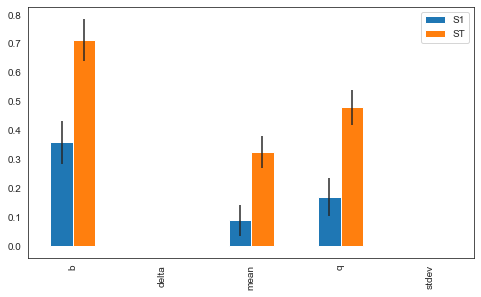

In [8]:
# Visualising Policy 1

scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [40]:
# Results policy 2

with MultiprocessingEvaluator(model) as evaluator:
    sa_results_2 = evaluator.perform_experiments(scenarios=1000, policies = policy_2,
                                               uncertainty_sampling='sobol')

experiments, outcomes = sa_results_2

problem = get_SALib_problem(model.uncertainties)
Si_2 = sobol.analyze(problem, outcomes['reliability'],
                   calc_second_order=True, print_to_console=False)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 1 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


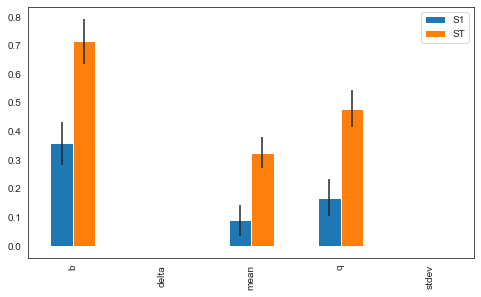

In [41]:
# Visualising Policy 2

scores_filtered_2 = {k:Si_2[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df_2 = pd.DataFrame(scores_filtered_2, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df_2[['S1','ST']]
err = Si_df_2[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [42]:
# Results policy 3

with MultiprocessingEvaluator(model) as evaluator:
    sa_results_3 = evaluator.perform_experiments(scenarios=1000, policies = policy_3,
                                               uncertainty_sampling='sobol')

experiments, outcomes = sa_results_3

problem = get_SALib_problem(model.uncertainties)
Si_3 = sobol.analyze(problem, outcomes['reliability'],
                   calc_second_order=True, print_to_console=False)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 1 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


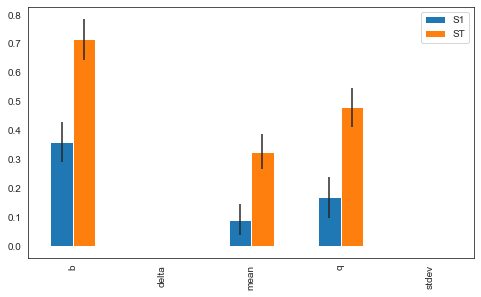

In [43]:
# Visualising Policy 3

scores_filtered_3 = {k:Si_3[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df_3 = pd.DataFrame(scores_filtered_3, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df_3[['S1','ST']]
err = Si_df_3[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [48]:
print(Si['S1'], Si_2['S1'], Si_3['S1'])

[ 3.59611432e-01 -1.49161743e-04  9.01119418e-02  1.69204769e-01
  8.76186441e-05] [ 3.59569358e-01 -2.06429123e-04  9.00865130e-02  1.69162853e-01
  5.45546046e-06] [3.59909465e-01 6.00013616e-06 9.06557329e-02 1.69474333e-01
 3.01419967e-04]


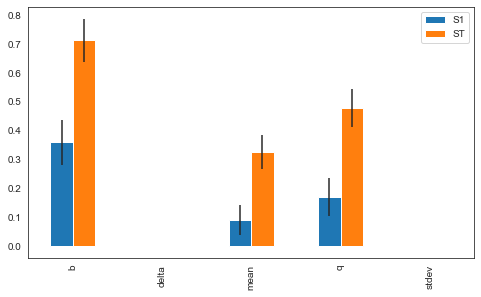

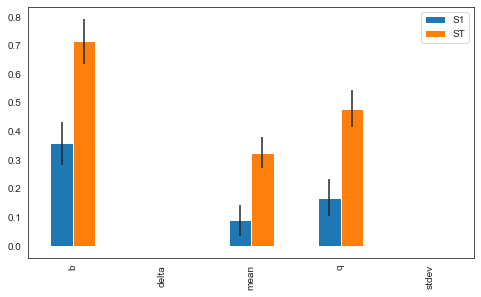

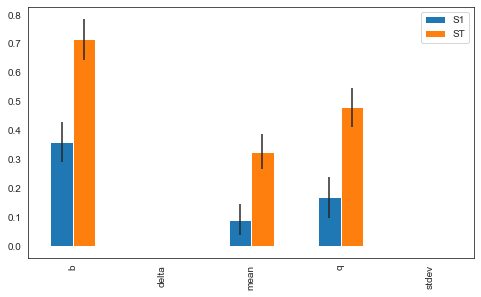

In [68]:
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df_2[['S1','ST']]
err = Si_df_2[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df_3[['S1','ST']]
err = Si_df_3[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

2. Repeat the above analysis for the 3 release policies but now with extra trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*


In [16]:
from ema_workbench.analysis import feature_scoring
import seaborn as sns


## Policy 1

In [31]:
with MultiprocessingEvaluator(model) as evaluator:
    rt_policy1 = evaluator.perform_experiments(scenarios=1000, policies = policy_1)
    rt_policy2 = evaluator.perform_experiments(scenarios=1000, policies = policy_2)
    rt_policy3 = evaluator.perform_experiments(scenarios=1000, policies = policy_3)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainP

In [35]:
experiments1, outcomes1 = rt_policy1
experiments2, outcomes2 = rt_policy2
experiments3, outcomes3 = rt_policy3

experiments1 = experiments1.drop(experiments1.columns.to_series()["0":"99"], axis=1)
experiments2 = experiments2.drop(experiments2.columns.to_series()["0":"99"], axis=1)
experiments3 = experiments3.drop(experiments3.columns.to_series()["0":"99"], axis=1)

random_trees1 = feature_scoring.get_feature_scores_all(experiments1, outcomes1)
random_trees2 = feature_scoring.get_feature_scores_all(experiments2, outcomes2)
random_trees3 = feature_scoring.get_feature_scores_all(experiments3, outcomes3)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

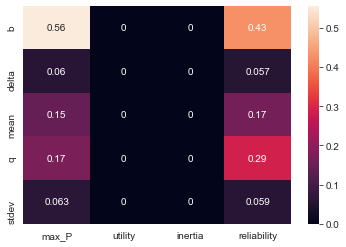

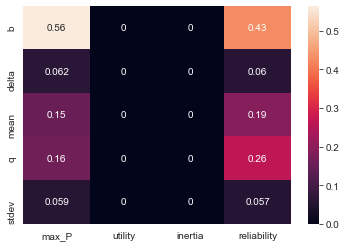

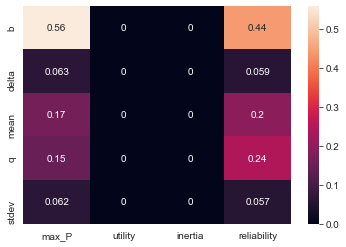

In [37]:
sns.heatmap(random_trees1, annot = True)
plt.show()
sns.heatmap(random_trees2, annot = True)
plt.show()
sns.heatmap(random_trees3, annot = True)
plt.show()